In [1]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

import cv2
import Augmentor as au

import unet_kkweon


from IPython import display
%matplotlib inline



In [2]:
def show(im, i = None, figsize =None):
    if len(im.shape) == 3:
        to_show = im[:,:,i]
    else:
        to_show = im
        
    if not figsize is None:
        plt.figure(figsize=(figsize))
    plt.imshow(to_show, cmap='gray')
    plt.show()
    

In [888]:
def plot_all(image):
    n = im.shape[2]
    f, a = plt.subplots(1, n, figsize=(15,18))
    for i in range(n):
        a[i].imshow(image[:,:,i], cmap = 'gray')
    plt.show()

In [3]:
from tqdm import tqdm, tqdm_notebook
import time

In [4]:
path = "../data/stage_1_processed/"

### Load data

In [5]:
# train_names = os.listdir(path + "train")
# val_names = os.listdir(path + "val")

In [6]:
names = os.listdir("../data/stage_1_processed/")

In [73]:
train_data = [np.load(path + name) for name in names[:620]]
val_data = [np.load(path + name) for name in names[620:]]

In [8]:
# train_data = [np.concatenate((x,
#                               np.expand_dims(cv2.morphologyEx(x[:,:,1], cv2.MORPH_GRADIENT, np.ones((2,2))),2)), -1)\
#               for x in train_data ]

In [74]:
def norm_mask(x):
    x[:,:,1] = (x[:,:,1] >= 1).astype(int)
    return x
    
def norm_im(x):
    x[:,:,0] = x[:,:,0] - x[:,:,0].min()
    x[:,:,0] = x[:,:,0] / x[:,:,0].max()
    return x

def separate_masks(x):
    x[:,:,1] = (x[:,:,1] - x[:,:,2]) > 0
    return x

train_data = [separate_masks(norm_im(norm_mask(x))) for x in train_data]
val_data = [separate_masks(norm_im(norm_mask(x))) for x in val_data]

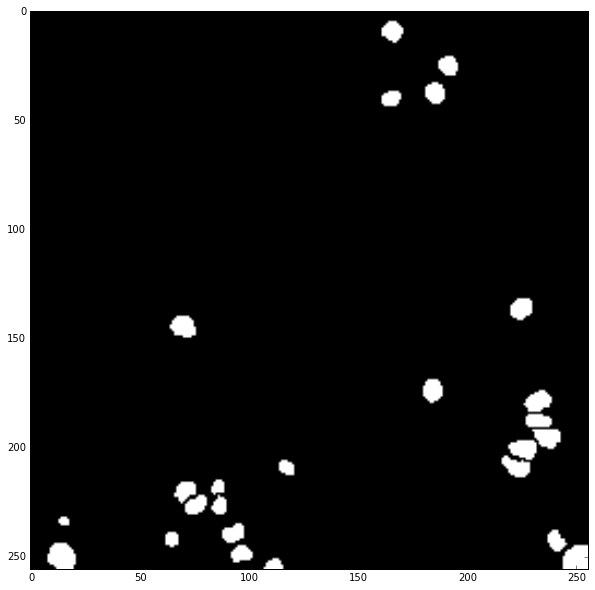

In [76]:
plt.figure(figsize = (10,10))
plt.imshow(train_data[4][:,:,1],cmap='gray')
plt.show()

In [466]:
def get_weights_for_loss(mask):
    circle5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    return (cv2.filter2D(mask,-1,circle5) / max(cv2.filter2D(mask,-1,circle5).max(), 1) *2 ) + 1 

3.0


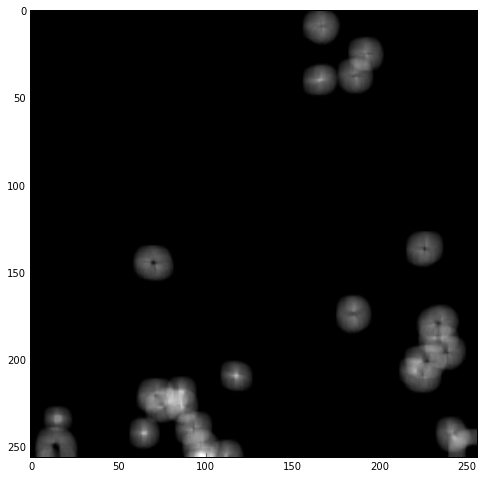

In [376]:
print(get_weights_for_loss(train_data[4][:,:,2]).max())
show(get_weights_for_loss(train_data[4][:,:,2]), figsize=(8,8))

### Create network and session

In [33]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [895]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [896]:
x = tf.placeholder("float", shape=[None, None, None, 1])

In [897]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

out = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [898]:
target = tf.placeholder("float", shape=[None, None, None, 1])
loss_mask = tf.placeholder("float", shape=[None, None, None, 1])
lr = tf.placeholder('float')

In [899]:
#out_logits = make_unet(x, training)

In [900]:
#out = tf.nn.sigmoid(out_logits)

In [901]:
#axis=np.arange(1,len(self.output_shape)+1)
# offset = 1e-5
# corr = tf.reduce_sum(target * out)#, axis=axis)
# l2_pred = tf.reduce_sum(tf.square(out))
# l2_true = tf.reduce_sum(tf.square(target))
# dice_coeff = (2. * corr + 1e-5) / (l2_true + l2_pred + 1e-5)


# Second version: 2-class variant of dice loss
#corr_inv = tf.reduce_sum((1.-self.y_data_tf) * (1.-self.y_pred_tf), axis=axis)
#l2_pred_inv = tf.reduce_sum(tf.square(1.-self.y_pred_tf), axis=axis)
#l2_true_inv = tf.reduce_sum(tf.square(1.-self.y_data_tf), axis=axis)
#dice_coeff = ((corr + offset) / (l2_true + l2_pred + offset) +
#             (corr_inv + offset) / (l2_pred_inv + l2_true_inv + offset))

#loss = tf.subtract(1., tf.reduce_mean(dice_coeff))

In [902]:
loss = tf.reduce_mean(tf.losses.log_loss(target, out, weights=loss_mask))

#loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(target, out_logits))
#loss = mean_iou(out, target)

In [903]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta2=0.98)
train_step = optimizer.minimize(loss)

  9%|▉         | 56/620 [00:20<03:21,  2.80it/s]

In [477]:
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.initialize_variables(uninitialized_vars)
sess.run(init_new_vars_op)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


In [904]:
sess.run(tf.global_variables_initializer())

In [402]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [422]:
test_target = tf.placeholder("float", shape=[None, None, None, 1])
test_loss = tf.reduce_mean(tf.losses.log_loss(target, test_target, weights=loss_mask))

In [424]:
sess.run(test_loss, feed_dict={test_target:batch_y[:1], target:batch_y[:1], loss_mask:batch_mask[:1]})

-1.2322225e-07

In [435]:
sess.run(loss, feed_dict={x:batch_x[:1], target:batch_y[:1], loss_mask:batch_mask[:1]})

0.014691708

In [434]:
for i in range(100):
    sess.run([train_step, loss], feed_dict={x:batch_x[:1], target:batch_y[:1], loss_mask:batch_mask[:1], lr :0.001})

In [411]:
batch_x[:1].max()

1.0

In [412]:
batch_y[:1].max()

1.0

In [413]:
batch_mask[:1].max()

3.0

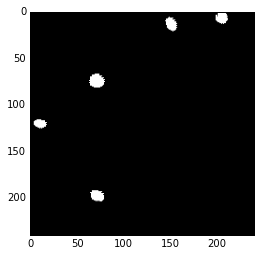

In [439]:
show(predict_proba(batch_x[0][:,:,:1]) > 0.5)

### Augmentation + batch_iterator

In [45]:
def mirror(im):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1,:], arr, arr[:,:(shape[1] // 2):-1,:]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:,:], arr, arr[:shape[0] // 2:-1,:,:]))

    return v(h(im))

In [46]:
u16_up = lambda x : int((x // 16 + 1) * 16)
u16_d = lambda x : int((x // 16) * 16)

In [47]:
def crop(im, shape=None):
    if shape is None:
        shape = (u16_d(im.shape[0] * 0.7), u16_d((im.shape[1] * 0.7)))
    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [48]:
def get_16_im(im):
    shape = im.shape
    big_im = mirror(im)
    pos_x = shape[0] // 2
    pos_y = shape[1] // 2
    
    
    shape_shift = (u16_up(shape[0]), u16_up(shape[1]))
    
    #prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(big_im[x: x + shape_shift[0], y : y + shape_shift[1], :], 0), training : False})
    return big_im[pos_x: pos_x + shape_shift[0], pos_y : pos_y + shape_shift[1],:]

In [49]:
import revertable_augmentator as ra
from importlib import reload
ra = reload(ra)

In [50]:
def iterate_minibatches(x, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt]

## Prediction

In [52]:
def validate_simple(data, prediction_func, cut_off=0.5):
    predictions = [prediction_func(im[:,:,:1]) for im in data]
    ground_truth = [im[:,:,1:2] for im in data]
    
    IOU = 0
    for t,p in tqdm(zip(ground_truth, predictions)):
        #MAP += calculate_average_precision([x for x in prob_to_masks(t)], [x for x in prob_to_masks(p)])
        IOU += np.logical_and(t,p > cut_off).sum() / np.logical_or(t,p > cut_off).sum()

    return IOU / len(predictions)

In [333]:
def crop(im, shape=None):
    if shape is None:
        shape = (u16_d(im.shape[0] * 0.7), u16_d((im.shape[1] * 0.7)))

    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    if (im.shape[0] ==  shape[0]):
        x = 0
    else:
        x = np.random.randint(0, im.shape[0] - shape[0])
        
    if (im.shape[1] == shape[1]):
        y = 0
    else:
        y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [875]:
def transform(im):
    transformation = ra.Transformation.generate_random_transformation(mirror(im))
    #transformation = ra.Transformation.generate_geometrical(mirror(im))
    return crop(transformation.apply(mirror(im)), im.shape)

In [893]:
ra=reload(ra)
#imgs = np.array([transform(im) for im in train_data[:]])

In [877]:
im = train_data[0].copy()

In [889]:
im_t = transform(im)
#im_t, m = ra.affine_smooth(mirror(im), rotation=10, shear=-30)

(2, 3)


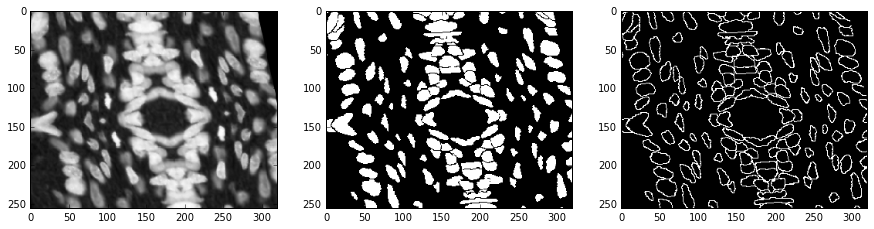

In [890]:
plot_all(crop(im_t, im.shape[:2]))

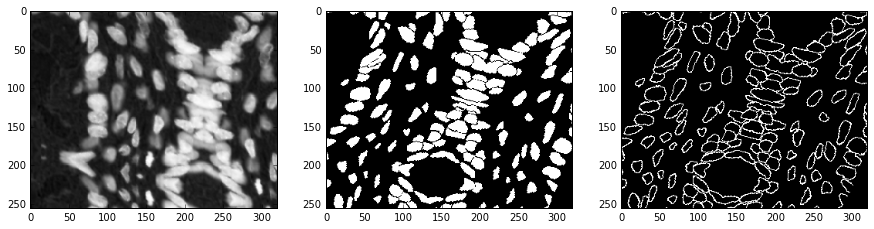

In [891]:
plot_all(imgs[0])

In [894]:
%time imgs = np.array([transform(im) for im in tqdm(train_data[:])])

  9%|▉         | 56/620 [00:05<01:00,  9.35it/s]

KeyboardInterrupt: 

In [905]:
train_loss = []
val_scores = []
val_loss = []

In [906]:
val_crop = [crop(x, (256, 256, 3)) for x in val_data]

In [907]:
epochs = 20

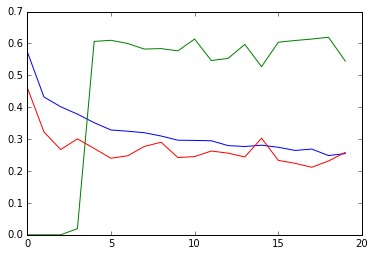

In [908]:
for epoch in range(epochs):
    curr_loss = 0
    imgs = np.array([transform(im) for im in tqdm_notebook(train_data[:])])
    #imgs = np.array([im for im in train_data[:]])
    for i, (batch) in tqdm(enumerate(iterate_minibatches(imgs[:],20))):
        shapes = np.concatenate(([np.array(image.shape).reshape(1, -1) for image in batch]))
        batch_shape = (u16_d(shapes[:,0].min() - 1), u16_d(shapes[:,1].min() - 1))
        images = [crop(im, batch_shape) for im in batch]
        
        batch_x = np.concatenate([np.expand_dims(im[:,:,:1],0) for im in images], 0)
        batch_y = np.concatenate([np.expand_dims(im[:,:,1:2],0) for im in images], 0)    
        batch_mask = np.concatenate([np.expand_dims(np.expand_dims(get_weights_for_loss(im[:,:,2:]),0),3) for im in images], 0)
        
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x, target: batch_y, loss_mask: batch_mask, lr : 0.001})
        curr_loss += batch_loss[1]
        #print(curr_loss)

    train_loss.append(curr_loss / (i + 1)) 
    
    val_score = validate_simple(val_data, predict)            
    val_scores.append(val_score)
    
    
    val_x = np.concatenate([np.expand_dims(im[:,:,:1],0) for im in val_crop], 0)
    val_y = np.concatenate([np.expand_dims(im[:,:,1:2],0) for im in val_crop], 0)    
    val_mask = np.concatenate([np.expand_dims(np.expand_dims(get_weights_for_loss(im[:,:,2:]),0),3) for im in val_crop], 0)
    val_loss.append(sess.run(loss, feed_dict={x:val_x, target:val_y, loss_mask:val_mask}))
    
    
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')

    plt.show()
            

In [338]:
val_x = np.concatenate([np.expand_dims(im[:,:,:1],0) for im in val_crop], 0)
val_y = np.concatenate([np.expand_dims(im[:,:,1:2],0) for im in val_crop], 0)    
val_mask = np.concatenate([np.expand_dims(np.expand_dims(get_weights_for_loss(im[:,:,2:]),0),3) for im in val_crop], 0)
val_loss.append(sess.run(loss, feed_dict={x:val_x, target:val_y, loss_mask:val_mask}))

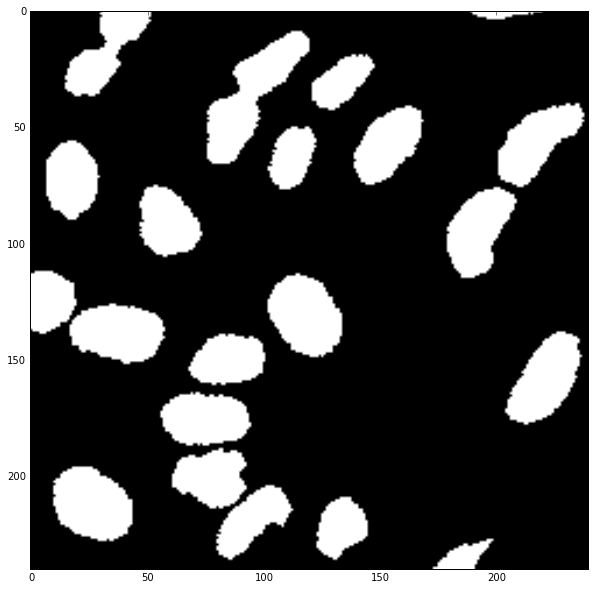

In [912]:
idx = 3
show(batch_y[idx ], 0, figsize=(10,10))

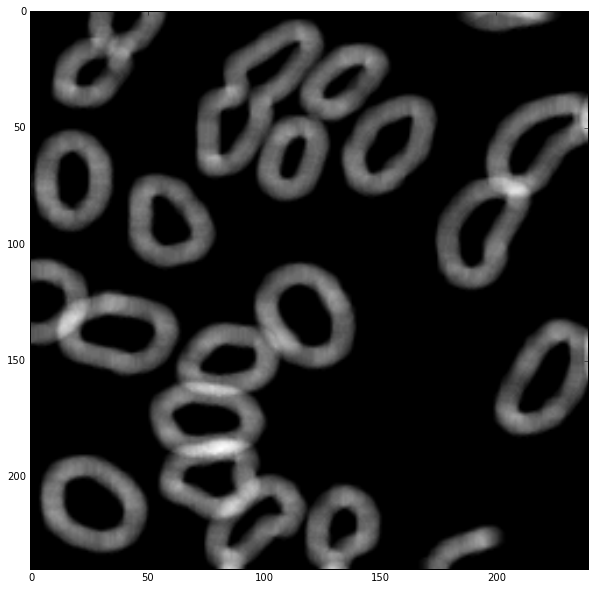

In [913]:
show(batch_mask[idx], 0, figsize=(10,10))

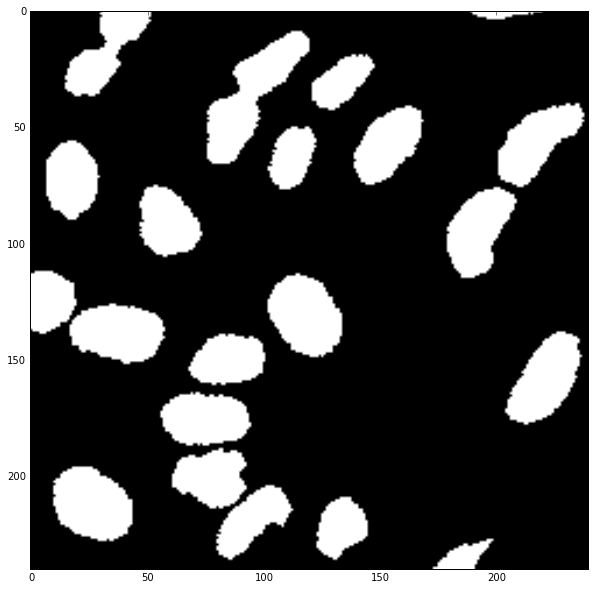

In [914]:
show(batch_y[idx ], 0, figsize=(10,10))

In [915]:
prediction = predict_proba(val_data[0][:,:,:1])

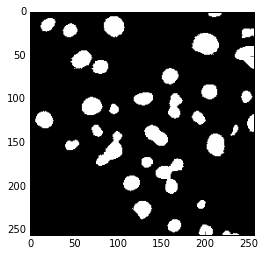

In [926]:
show(prediction >0.6, 0)

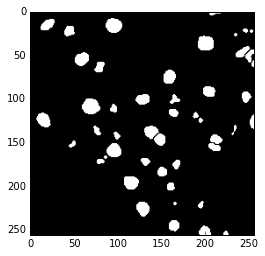

In [929]:
show(val_data[0], 1)

In [1151]:
import pickle

In [1152]:
def save_state():
    state = {}
    for var in tf.all_variables():
        state[var.name] = sess.run(var)
    return state

pickle.dump(save_state, open("../model/begining_of_dice", 'wb'))

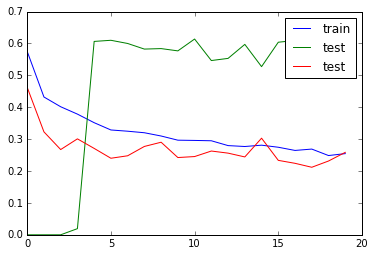

In [931]:
plt.plot(train_loss, label='train')
plt.plot(val_scores, label='test')
plt.plot(val_loss, label='test')
plt.legend()
plt.show()

In [932]:
def predict_resize(im, steps = 2):
    shape = im.shape
    im_16 = get_16_im(im)

    #prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0), training : 0})[0]
    prediction = np.zeros([shape[0], shape[1], 2])
    
    for i in np.linspace(0.9, 1.1, 2*steps - 1):
        #print(i)
        trnsf = ra.Transformation(im_16, ratios=np.array([1,1]) * i)
        im_resized = trnsf.apply(im_16, True)
        shape_resized = im_resized.shape
        
        im_resized_16 = get_16_im(im_resized)
        pred_resized = sess.run(out, feed_dict={x : np.expand_dims(im_resized_16, 0)})[0][:shape_resized[0],:shape_resized[1]]
        
        
        trnsf_inv = ra.Transformation(pred_resized, ratios=np.array([1,1]) / i)
        
        pred_original_shape = cv2.morphologyEx(trnsf_inv.apply(pred_resized, False)[:shape[0],:shape[1]], cv2.MORPH_CLOSE, np.ones((3,3)))
        
#         print(pred_resized.max())
#         show(pred_original_shape,0)
#         print(pred_original_shape.max())
        prediction += pred_original_shape
        
    #prediction = prediction[:,:,0]
    return prediction / (2*steps -1)

In [933]:
import skimage

In [934]:
def predict_flip(im):
    shape = im.shape
    if im.shape[0] > 1000 and im.shape[1] > 1000:
        im_pred = skimage.exposure.adjust_gamma(im, 0.3)
    else:
        im_pred = im.copy()
    im_16 = get_16_im(im_pred)
    #im_16 = im
    prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0)})[0] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[::-1], 0)})[0][::-1] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[:,::-1], 0)})[0][:,::-1] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[::-1,::-1], 0)})[0][::-1,::-1]
    prediction = prediction[:,:,0] - prediction[:,:,1]
    #rediction = prediction[:,:,0]
    
    prediction = prediction / 4
    prediction = prediction[:shape[0],:shape[1]]
    
    circle5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, circle5)
    rediction = cv2.morphologyEx(prediction, cv2.MORPH_CLOSE, circle5)
    
    return np.expand_dims(prediction,2)

In [944]:
from skimage.morphology import label
def predict_proba(im):
    shape = im.shape
    im_16 = get_16_im(im)
    #im_16 = im
    prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0)})[0]    
    
    prediction = prediction[:shape[0],:shape[1]]
    #prediction = prediction[:,:,0] - prediction[:,:,1]
    
    #circle3=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    #prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, circle3)
        
    return prediction[:,:,:]

In [936]:
def predict(im, cut_off = 0.5):
    proba = predict_proba(im)
    return np.expand_dims((proba > cut_off).astype(int), 2)

In [937]:
def predict_random(im, num = 5):
    shape = im.shape[:2]
    party_pred = np.expand_dims(np.zeros(shape),2)
    
    im_m = mirror(im.copy())
    
    trfs = [ra.Transformation(im_m.copy(), 0,1,1,1,-5,10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 1,1,1,1,-5,10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 0,0.5,0,0,5,-10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 1,1,1,1,5,-10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 0,1,0,0,0,0,np.array([1,1])),
           ]
    
#     for i in range(num):
#         im_m = mirror(im.copy())
#         trf = ra.Transformation.generate_random_transformation(im_m)
    for trf in trfs[:num]:
        im_to_pred = trf.apply(im_m)
        pred = predict_flip(im_to_pred[:,:,:1]) # > 0.5).astype(int)[:,:,:]           
                    
        pred_inv = trf.apply_inverse(pred)[pred.shape[0] // 4 : pred.shape[0] // 4 + shape[0],
                                          pred.shape[1] // 4 : pred.shape[1] // 4 + shape[1]]
        
        
        party_pred += pred_inv

                      
    return party_pred / num

In [938]:
ind = 6
#pred = (predict_flip(skimage.exposure.adjust_gamma(val_data[ind], 1)[:,:,:1]) > 0.5)[:,:,0]

In [1022]:
pred = (predict_random(val_data[ind], 5) > 0.5)[:,:,0]

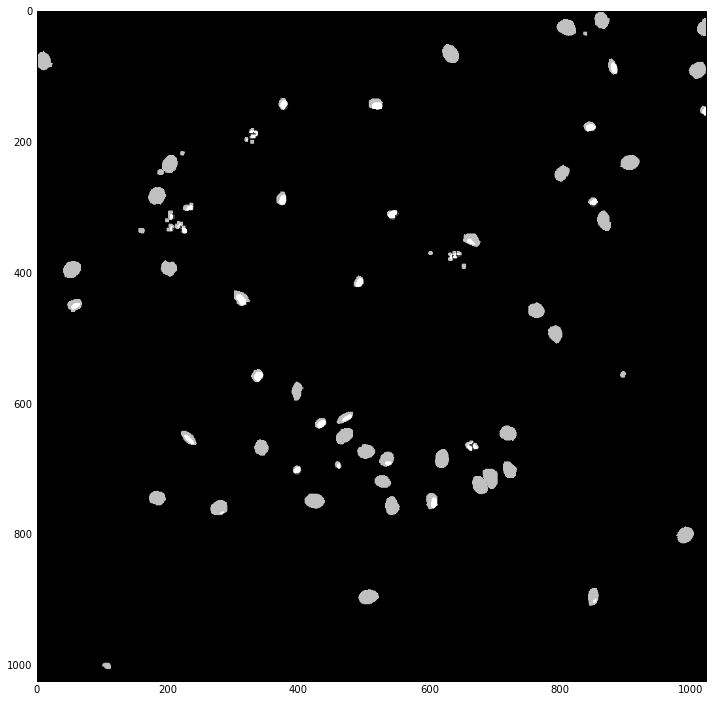

In [1023]:
show(pred[:,:] + val_data[ind][:,:,1] * 3 ,figsize= (12,12))

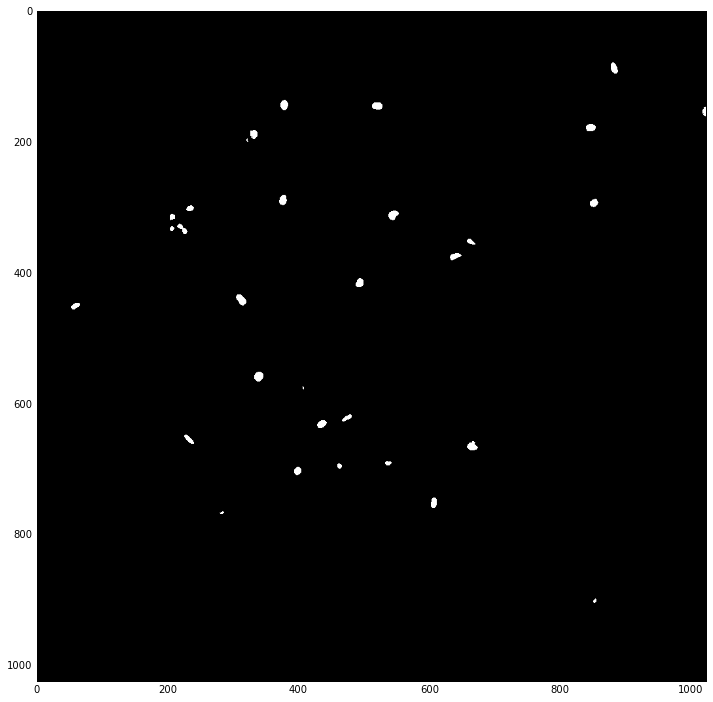

In [1024]:
show(pred, 0  ,figsize= (12,12))

In [941]:
validate_simple(val_data[:], predict)


0it [00:00, ?it/s]
38it [00:00, 372.86it/s]
44it [00:00, 402.14it/s]

0.54499959924759822

In [764]:
validate_simple(val_data[:], predict_flip)

44it [00:00, 706.47it/s]


0.7124797340294684

In [949]:
for i in np.arange(0.5, 0.7, 0.025):
    print(i, validate_simple(val_data[:], predict_proba, i))

44it [00:00, 442.89it/s]


0.5 0.544999599248


44it [00:00, 454.56it/s]


0.525 0.556066158056


44it [00:00, 439.23it/s]


0.55 0.566856359941


44it [00:00, 437.64it/s]


0.575 0.576243381344


44it [00:00, 417.99it/s]


0.6 0.58424368267


44it [00:00, 453.71it/s]


0.625 0.590224952665


44it [00:00, 448.85it/s]


0.65 0.59252997582


44it [00:00, 370.15it/s]

0.675 0.591594593153


In [739]:
validate_simple(val_data[:], predict)

44it [00:00, 733.37it/s]


0.69717794325358073

In [825]:
validate_simple(val_data[:], predict_resize)

44it [00:00, 567.41it/s]


0.5857522154802155

In [996]:
def validate(data,prediction_func,cut_off=0.65):
    predictions = [predict_proba(im[:,:,:1]) for im in data]
    #print(predictions[0].shape)
    ground_truth = [im[:,:,1:2] for im in data]
    
    MAP = 0
    for t,p in tqdm(zip(ground_truth, predictions)):
        
        MAP += calculate_average_precision([x for x in prob_to_masks(t,cut_off,1)], [x for x in prob_to_masks(p,cut_off,3)])
    
    return MAP / len(predictions)

In [ ]:
validate(val_data[:], predict, 0.8)

44it [04:47,  6.52s/it]


0.1517593310180837

In [ ]:
print("322")

In [1025]:
idx = 3
pred = predict_proba(val_data[idx][:,:,:1])

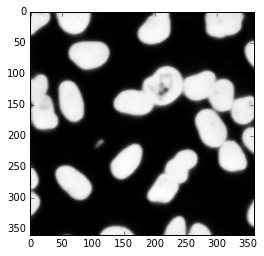

In [1030]:
show(pred, 0)

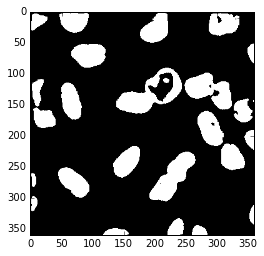

In [1032]:
show(sum([x for x in prob_to_masks(pred,0.8,5)]))

In [1034]:
calculate_average_precision([x for x in prob_to_masks(val_data[idx][:,:,1])],[x for x in prob_to_masks(pred,0.8,3)])

0.22109457258080539

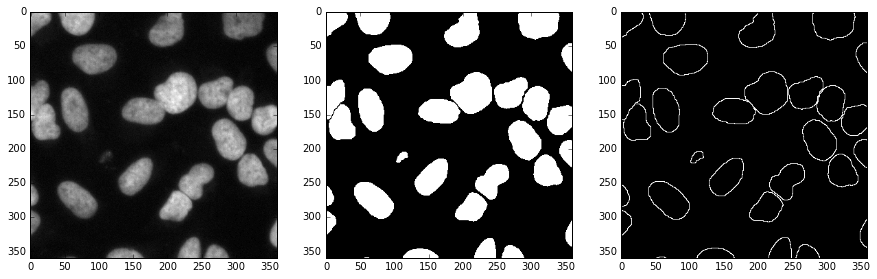

In [1028]:
plot_all(val_data[idx])

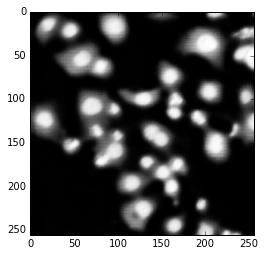

In [975]:
show(pred, 0)

In [745]:
validate(val_data[:2], predict_resize)

A Jupyter Widget

0.15466333127309753

In [529]:
strange.max()

0.0047676763113807235

In [486]:
validate(val_data[:2])

2it [00:34, 17.01s/it]


0.37292384131620637

In [984]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        
def prob_to_masks(x, cut_off = 0.5, close_size = 1):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        curr = (lab_img==i).astype('uint8')
        circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(close_size,close_size))
        yield cv2.morphologyEx(curr.copy(), cv2.MORPH_OPEN, circle)
        #yield (lab_img==i).astype('uint8')

In [948]:
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds

def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    for i, p_mask in (enumerate(pred_masks)):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

## PREDICT

In [1037]:
path = "../data/1_stage_test_proc/"

In [1038]:
test_names = os.listdir(path)

In [1039]:
import pandas as pd

In [1040]:
sample_submition = pd.read_csv("../data/stage1_sample_submission.csv")

In [1068]:
answ = pd.DataFrame(columns=sample_submition.columns)
answ.head()

,ImageId,EncodedPixels


In [1069]:
test_preds = []
test_ims = []

In [1070]:
num = 0
for name in tqdm(test_names[:]):
    im = np.load(path + name).astype(float)
    im = norm_im(im)
    
    test_ims.append(im.copy())
    
    prediction = predict_proba(im[:,:,:1])[:,:,0]
    test_preds.append(prediction)
    
    
    rle_prediction = [[x for x in prob_to_rles(x)] for x in prob_to_masks(prediction, 0.7, 3)]
    for p in rle_prediction:
        answ.loc[num] = np.array([name[1:-4], ' '.join([str(el) for el in p[0]])])
        num += 1

100%|██████████| 65/65 [00:15<00:00,  4.15it/s]


In [1067]:
answ.head()

,ImageId,EncodedPixels
0,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,79659 1 80180 8 80192 1 80702 18 81225 20 8174...
1,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,56597 5 57120 8 57643 10 58167 11 58691 12 592...
2,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,66554 2 67077 5 67600 10 68123 13 68648 2 6865...
3,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,146725 1 147248 3 147772 4 148296 4 148821 4 1...
4,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,161401 5 161924 7 162447 9 162970 11 163493 12...


In [1137]:
test_names[0][1:-4]

'c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb'

In [1139]:
num = 0
for name, pred in zip(test_names, test_preds):
    rle_prediction = prob_to_rles(pred, 0.5)
    for p in rle_prediction:
        answ.loc[num] = np.array([name[1:-4], ' '.join([str(el) for el in p])])
        num += 1

In [1071]:
answ.to_csv("../data/baseline_answ.csv", index = False)

In [1158]:
test_ims[0].shape[:2]

(524, 348)

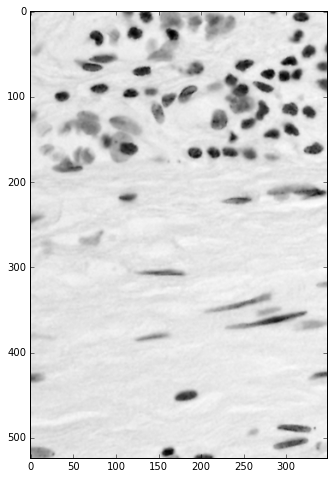

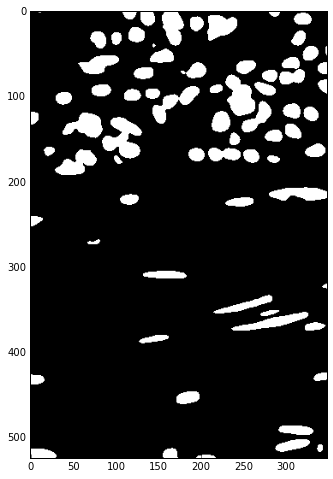

In [1162]:
idx = 0
show(test_ims[idx], 0, (8,8))
show(test_preds[idx] > 0.5, 0, (8,8))

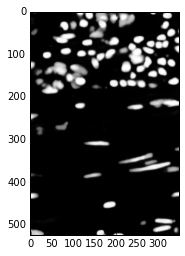

In [1126]:
show(test_preds[0], 0)

In [876]:
answ["ImageId"].values[0][:-3]

'c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb.'

In [770]:
test_data = [np.load(path + name) for name in test_names]


In [774]:
test_data = [norm_im(x) for x in test_data]

In [1066]:
show(test_data[0].astype(float),0)

NameError: name 'test_data' is not defined

In [791]:
test_pred = [predict(k[:,:,:1]) > 0.625 for k in test_data]